# Exploratory Text Analysis

In this notebook, we will explore the text data of the dataset, Checking the frequency of messages, intents, words, sentiments and other stuff. Will be a basic text analysis.

This notebook have a dataset in Portuguese as example, but it can be used in any language, you just need to change the raw data files.

## 1. Import

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt

%matplotlib inline

## 2. Load data

#### 2.1 Examples

In [2]:
phrase = pd.read_parquet('../data/raw/examples/raw-phrase.parquet')
target = pd.read_parquet('../data/raw/examples/raw-target.parquet')

examples = pd.concat([phrase, target], axis = 1)	
examples.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 434 entries, 0 to 433
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   phrase  434 non-null    object
 1   intent  434 non-null    object
dtypes: object(2)
memory usage: 6.9+ KB


#### 2.2 Responses

In [3]:
responses = pd.read_parquet('../data/external/responses-phrases.parquet')
responses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   intent    23 non-null     object
 1   response  23 non-null     object
dtypes: object(2)
memory usage: 496.0+ bytes


#### 2.3 Sentiment Analysis

In [4]:
phrase = pd.read_parquet('../data/raw/sentiments/raw-phrase.parquet')
target = pd.read_parquet('../data/raw/sentiments/raw-target.parquet')

sentiment_analysis = pd.concat([phrase, target], axis = 1)	
sentiment_analysis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99384 entries, 0 to 99383
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   phrase  99384 non-null  object
 1   target  99384 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


## 3. Explore data

### 3.1 Data overview

In [5]:
examples.sample(10)

,phrase,intent
256,Como faço para tranferir do aplicativo para ou...,realizar_transferencia
153,Excedi números de tentativas e bloqueou o app,desbloquear_app
102,Como falar com o gerente da minha conta,conhecer_contatos
106,Gostaria de ligar para um atendente,conhecer_contatos
71,Quero fazer uma alteração de limite de crédito,alterar_limite_cartao
349,Quero fazer refinanciamento,solicitar_acordo
300,Como criar a senha,alterar_senha
57,Gostaria de saber se consigo alterar o endereç...,alterar_dados_cadastrais
121,Consta que tenho um débito em aberto com vocês,conhecer_divida
86,Fazer instalação do aplicativo,baixar_app


In [6]:
responses.sample(10)

,intent,response
9,desbloquear_cartao,"Para desbloquear seu cartão, basta você entrar..."
8,desbloquear_app,"Ok, para desbloquear você precisa confirmar se..."
19,solicitar_acordo,"Ok, você pode solicitar um acordo pelo Aplicat..."
6,conhecer_divida,"Humm... Para saber sua dívida, você precisa ac..."
11,falar_atendente,"Desculpa se não consegui te ajudar, vou te pas..."
0,abrir_conta,Legal! Fico feliz por saber que quer abrir uma...
14,rastrear_cartao,"Ok, preciso que me fale seu CPF para que eu po..."
18,relatar_problemas_app,Está com problemas no App?! Você pode contatar...
1,acessar_conta,"Ok! Para acessar a sua conta, você precisa bai..."
12,liberar_dispositivo,Claro! Podemos liberar seu dispositivo. Para i...


### 3.2 Intents Distribution

In [9]:
# count the number of phrases per intent
intents_count = examples.intent.value_counts()

print('Number of different intents:', len(intents_count.index))
print('Number of phrases:', intents_count.sum())
print('Median number of phrases:', intents_count.median())

Number of different intents: 24
Number of phrases: 434
Median number of phrases: 16.5


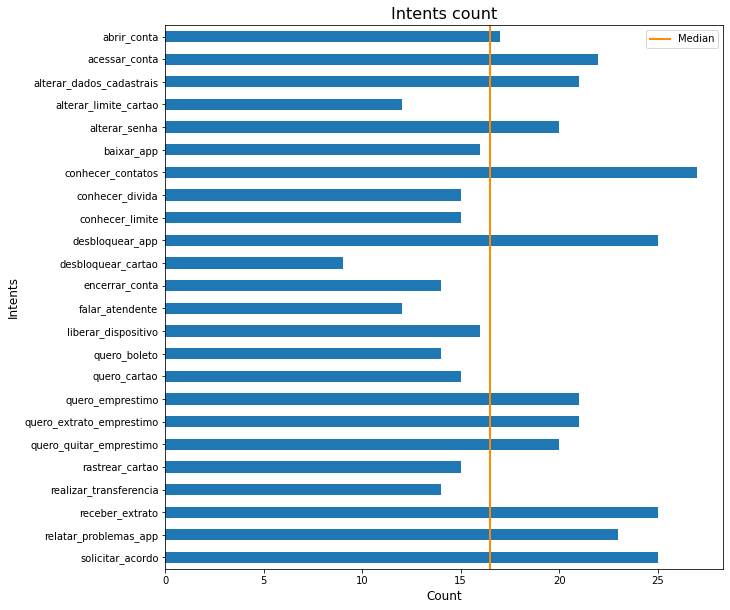

In [ ]:
intents_count.sort_index(ascending = False).plot.barh(figsize = (10, 10))
plt.axvline(intents_count.median(), color = 'darkorange', linewidth = 2)
plt.title('Intents count', fontsize = 16)
plt.xlabel('Count', fontsize = 12)
plt.ylabel('Intents', fontsize = 12)
plt.legend(['Median'])
plt.show()

How is possible to note the dataset has unbalanced intents with different numbers of examples. So is necessary to balance our dataset with some techniques. In this case, we will use the technique of oversampling and data augmentation to generate more examples. Oversampling will be used when we will make the train data.

### 3.3 Phrases Distribution

In [ ]:
examples.phrase.value_counts()

O que fazer para liberar aplicativo                         4
Estou tentando desbloquear meu aplicativo no meu celular    2
Aplicativo está bloqueado                                   2
Quero alterar o limite do meu cartão de crédito             2
Quero desbloquear meu aplicativo                            2
                                                           ..
Qual o limite que vai vir no cartão?                        1
Quero saber quanto posso gastar no cartão                   1
Saber quanto tenho de limite                                1
Quero saber qual é meu limite                               1
Saber desconto do empréstimo                                1
Name: phrase, Length: 423, dtype: int64

In [ ]:
examples.query('phrase == "O que fazer para liberar aplicativo"')

,phrase,target
150,O que fazer para liberar aplicativo,desbloquear_app
158,O que fazer para liberar aplicativo,desbloquear_app
215,O que fazer para liberar aplicativo,liberar_dispositivo
331,O que fazer para liberar aplicativo,relatar_problemas_app


As we can see above, we have identical phrases with different intents. This is not a good situation because it can confuse our model. We will drop similar phrases. We need to drop these rows.

### 3.4 Most used words

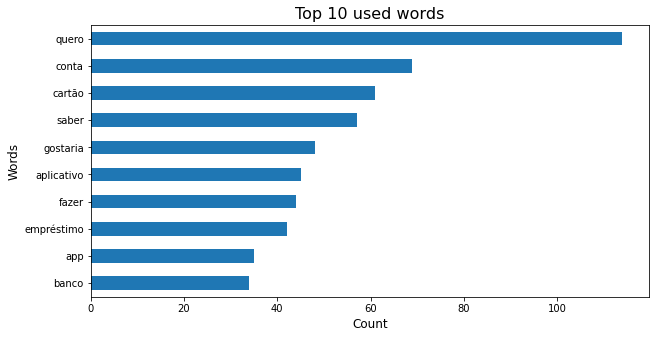

In [ ]:
# listing words
words = examples.phrase.str.lower().apply(str.split).sum()

# reading portuguese stopwords
stopwords = open('../data/external/stopwords.csv', 'r').read().split('\n')

# removing stopwords
words = pd.Series(filter(lambda word: word not in stopwords, words))

top_ten_words = words.value_counts().head(10)
top_ten_words.plot.barh(figsize = (10, 5)).invert_yaxis()
plt.title('Top 10 used words', fontsize = 16)
plt.xlabel('Count', fontsize = 12)
plt.ylabel('Words', fontsize = 12)
plt.show()

The portuguese verb 'Quero' (Want) is the most user word in the dataset. So we can infer that the majority of intents are about Want something such as credit card, bills and other stuff.

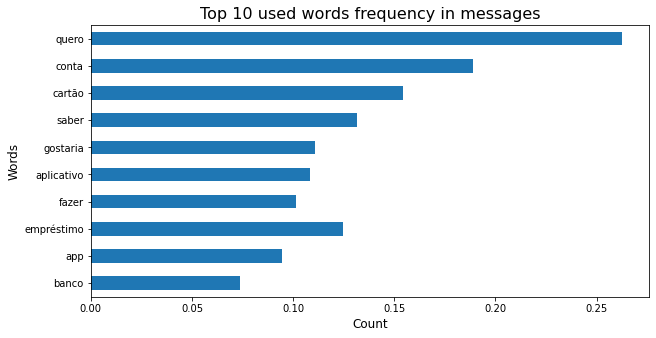

In [ ]:
def word_frequency(word):
    return examples.phrase.str.lower().apply(lambda message: word in message).sum() / examples.shape[0]
    
top_ten_words_frequency = top_ten_words.index.to_series().apply(word_frequency)

top_ten_words_frequency.plot.barh(figsize = (10, 5)).invert_yaxis()
plt.title('Top 10 used words frequency in messages', fontsize = 16)
plt.xlabel('Count', fontsize = 12)
plt.ylabel('Words', fontsize = 12)
plt.show()

The verb 'Quero' (Want) appear in 26% of the dataset messages, followed by 'Conta' (Account) and 'Cartão' (Credit Card).

### 3.5 Sentiment Analysis

This dataset contains several tweets in Portuguese tagged as positive, negative or neutral. This dataset will be used to train a sentiment analysis model.

We have three classes of sentiment:
*  positive: messages that are positive, like "I am happy";
*  negative: messages that are negative, like "I am sad";
*  neutral: messages that are neutral, like "I am not sure".

In [ ]:
sentiment_analysis.head(10)

,phrase,sentiment
61472,Ja nem sei o que eu faço da minha vida :(,negative
18967,"@UncleDeathMono vamos sim, só me chamar :)",positive
91895,Você sabia? #curiosidade Caso Ciro Gomes vença...,neutral
28418,Ja devia de saber que tens papos com todas :)),positive
51921,"Caralho, eu tô muito assustada. E pensar que m...",negative
35920,Anjo da minha vida :( https://t.co/K2pXx7Yx7X,negative
4793,@maldsuado *andava a apanhar :),positive
21085,mais 1 mês sem nenhum real no bolso comendo o ...,positive
35632,Recebi um áudio da minha vó dizendo que tá mui...,negative
62188,oi @hyuckpetit te amo :((,negative


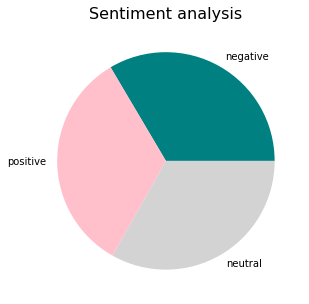

In [ ]:
sentiment_analysis.sentiment.value_counts().plot.pie(figsize = (10, 5), colors = ['teal', 'pink', 'lightgrey'])
plt.title('Sentiment analysis', fontsize = 16)
plt.ylabel('')
plt.show()

These classes are balanced, they have the same number of examples. This is a good sign, we don't need to balance our dataset.

In [ ]:
sentiment_analysis[sentiment_analysis.phrase.str.contains('@')]#.sample(20)

,phrase,sentiment
1,"@UncleDeathMono vamos sim, só me chamar :)",positive
6,@maldsuado *andava a apanhar :),positive
9,oi @hyuckpetit te amo :((,negative
10,@caioumrb @DantonTT aqui :) https://t.co/m6t5J...,positive
11,@MohMedeiros @jhonhenriquers pessoas invisívei...,negative
...,...,...
99373,"@larissnobrega aí se chegar num ponto, tipo no...",positive
99376,@FuckLagolas To precisando.. :),positive
99378,@columbineshots queria ser :(,negative
99382,&gt;@brdezoito Fabricante de armas em alta na ...,neutral


Tweets contain some words with '@' and '#' characters. These characters are used to tag the tweets as a user mention or a hashtag. We need to drop these words. In addition, some words are not useful, like '&gt' and 'https' (URL). We need to drop these words.

We will do it to minimize the number of words in our train dataset.

In [50]:
ph = pd.read_parquet('../data/raw/sentiments/raw-phrase.parquet')
tg = pd.read_parquet('../data/raw/sentiments/raw-target.parquet')

data = pd.concat([ph, tg], axis = 1)

In [51]:
data

,phrase,target
0,Ja nem sei o que eu faço da minha vida :(,negative
1,"@UncleDeathMono vamos sim, só me chamar :)",positive
2,Você sabia? #curiosidade Caso Ciro Gomes vença...,neutral
3,Ja devia de saber que tens papos com todas :)),positive
4,"Caralho, eu tô muito assustada. E pensar que m...",negative
...,...,...
99379,ah ele não escolheu jogar com a kassandra tô t...,negative
99380,"Dólar sobe quase 1,5% e vai a R$ 4,15 com reaç...",neutral
99381,Tem uma palestra na unisinos que o ingresso cu...,positive
99382,&gt;@brdezoito Fabricante de armas em alta na ...,neutral


In [43]:
palavras = pd.read_csv('https://raw.githubusercontent.com/pythonprobr/palavras/master/palavras.txt', encoding = 'utf-8')

In [45]:
palavras = list(palavras.values) + ['a']

In [53]:
'$' in palavras

False